In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab
import matplotlib.pyplot as plt
import pysal
from pysal import model
from pysal.lib import weights
import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from sklearn import cluster
import statsmodels.formula.api as sm

In [2]:
from FoliumPlot import folium_plot, folium_layout
from Functions import *

## Data Modeling

### Import data

In [3]:
# map path
data_path = 'data/st/data_st_city_per_geo'
data_st_city_per_geo = gpd.read_file(data_path)
data_st_city_per_geo.columns = pd.read_csv(data_path + '/col_name.csv').iloc[:, 0].to_list() + ['geometry']

data_st_city_per_geo.info()

In [4]:
# filter operator data
filter_col_model_market_share_operator = "DNA"
col_model_market_share_operator = "operator_name"

In [5]:
# model data
model_dataset = data_st_city_per_geo.query(
    "{} == @filter_col_model_market_share_operator".format(
        col_model_market_share_operator
    )
).reset_index(drop=True)

### calculate spatial weight matrix

In [6]:
# geo_weight = weights.KNN.from_dataframe(data_st_city_geo, k=1)
geo_weight = weights.Queen.from_dataframe(model_dataset)

# convert transform to 'R' to calculate spatial lag
geo_weight.transform = 'R'
print(geo_weight.neighbors)

{0: [1, 2, 3], 1: [0, 2, 3, 5, 12], 2: [0, 1, 35, 12], 3: [0, 1, 20, 5, 21], 4: [5, 6, 7], 5: [1, 3, 4, 20, 6, 7, 12], 6: [4, 5, 20, 7, 23, 27, 47], 7: [4, 5, 6, 41, 9, 11, 12, 13, 46, 47], 8: [32, 34, 42, 10, 46], 9: [35, 37, 7, 10, 11, 12, 13], 10: [32, 37, 8, 9, 11, 46], 11: [9, 10, 46, 7], 12: [1, 2, 35, 5, 7, 9, 13], 13: [9, 12, 7], 14: [16, 17, 22, 25], 15: [17, 18, 25], 16: [17, 19, 14], 17: [16, 18, 19, 25, 14, 15], 18: [17, 19, 15], 19: [16, 17, 18], 20: [3, 5, 6, 21, 24, 25, 27], 21: [25, 3, 20, 22], 22: [25, 21, 14], 23: [48, 6, 27, 28, 47], 24: [25, 26, 27, 20], 25: [17, 20, 21, 22, 24, 14, 15], 26: [24, 27, 28], 27: [20, 6, 23, 24, 26, 28], 28: [48, 49, 23, 26, 27], 29: [32, 33, 30, 31], 30: [33, 29, 39], 31: [32, 29, 37], 32: [33, 34, 37, 8, 10, 29, 31], 33: [32, 34, 39, 29, 30], 34: [32, 33, 39, 8, 42, 77, 78, 79, 61], 35: [2, 36, 37, 9, 12], 36: [35, 37], 37: [32, 35, 36, 9, 10, 31], 38: [40, 52, 39], 39: [33, 34, 38, 40, 30, 79], 40: [52, 38, 39, 76, 79], 41: [7, 43, 4

### spatial lag

In [7]:
# create new cols of spatial lag
col_lag = [_ for _ in model_dataset.columns if "4g_pct" in _]
for col in col_lag:
    model_dataset[col + "_lag"] = weights.lag_spatial(geo_weight, model_dataset[col])

### calculate spatial Moran-I and LISA

In [8]:
# Moran-I
col_ori = 'device_count_4g_pct'
col_new = 'device_count_4g_pct_lag'
mi = esda.Moran(model_dataset[col_ori], geo_weight)

print(mi.I, mi.p_sim)

0.4052378308132005 0.001


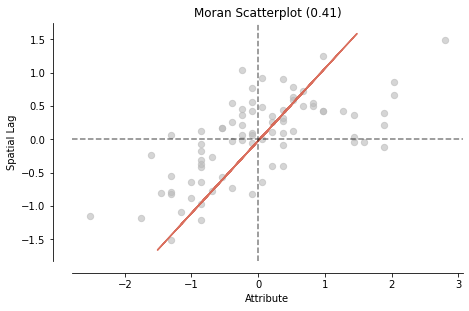

In [9]:
# plot moran
moran_scatterplot(mi)
plt.show()

In [10]:
# Local Indicators of Spatial Association (LISA)
lisa = esda.Moran_Local(model_dataset[col_ori], geo_weight)
significant = lisa.p_sim < 0.05
print(lisa.q)

[4 2 1 2 1 1 2 1 4 1 2 3 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 4 2 1 1 1 3
 2 2 2 4 3 3 3 3 3 3 3 3 2 2 1 4 2 1 4 3 3 3 3 3 3 3 3 3 3 4 1 1 1 3 3 3 3
 3 3 3 2 1 2]


(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

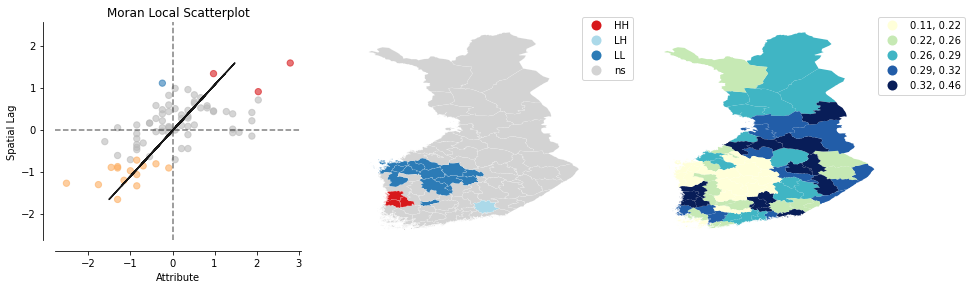

In [11]:
# plot correlations
plot_local_autocorrelation(lisa, model_dataset, col_ori)

### Visulize geo data

In [14]:
# vis col
col_plot = [
    "mid_dl_4g_pct",
    "mid_ul_4g_pct",
    'latency_4g_pct',
    "avg_rsrp_rscp_4g_pct",
    "device_count_4g_pct",
    "mid_dl_4g_pct_lag",
    "mid_ul_4g_pct_lag",
    'latency_4g_pct_lag',
    "avg_rsrp_rscp_4g_pct_lag",
    "device_count_4g_pct_lag",
]

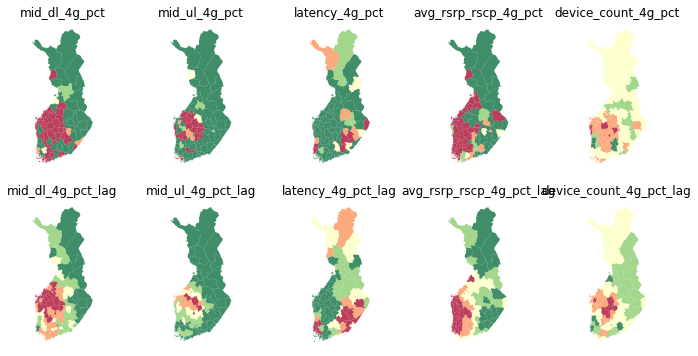

In [15]:
# Create figure and axes
_, axs = plt.subplots(nrows=2, ncols=int(len(col_plot) / 2), figsize=(12, 6))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the variables of interest
for i, col in enumerate(col_plot):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    model_dataset.plot(
        column=col,
        ax=ax,
        scheme="Equal_Interval",
        k=5,
        linewidth=0,
        cmap="RdYlGn",
        alpha=0.75,
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)

### KMeans clustering

<AxesSubplot:>

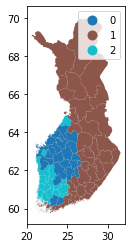

In [16]:
# col
col_model = ['mid_dl_4g_pct_lag',
             'mid_ul_4g_pct_lag',
             'latency_4g_pct_lag',
             'avg_rsrp_rscp_4g_pct_lag',
             'avg_snr_4g_pct_lag',
             'device_count_4g_pct_lag'
             ]

# model
clf_km = cluster.KMeans(n_clusters=3)
clf_km.fit(model_dataset[col_model])
model_dataset['km'] = clf_km.labels_

# plot
model_dataset.plot(column='km', categorical=True, legend=True, linewidth=0)

### AC clustering

<AxesSubplot:>

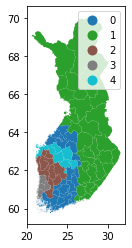

In [17]:
# model
clf_ac = cluster.AgglomerativeClustering(n_clusters=5, connectivity=geo_weight.sparse)
clf_ac.fit(model_dataset[col_model])
model_dataset['ac'] = clf_ac.labels_

# plot
model_dataset.plot(column='ac', categorical=True, legend=True, linewidth=0)

### spatial autocorrelation

In [19]:
# model col
col_model_X = [
    "mid_dl_4g_pct_lag",
    "mid_ul_4g_pct_lag",
    "latency_4g_pct_lag",
    "avg_rsrp_rscp_4g_pct_lag",
    "avg_snr_4g_pct_lag",
]
col_model_y = [
    "device_count_4g_pct_lag",
]
# data
X = model_dataset[col_model_X].values
y = model_dataset[col_model_y].values

In [20]:
# OLS model
m1 = model.spreg.OLS(np.log(y), X, name_y=col_model_y[0], name_x=col_model_X)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :device_count_4g_pct_lag                Number of Observations:          80
Mean dependent var  :     -1.2939                Number of Variables   :           6
S.D. dependent var  :      0.1526                Degrees of Freedom    :          74
R-squared           :      0.6833
Adjusted R-squared  :      0.6619
Sum squared residual:       0.583                F-statistic           :     31.9362
Sigma-square        :       0.008                Prob(F-statistic)     :   3.409e-17
S.E. of regression  :       0.089                Log likelihood        :      83.374
Sigma-square ML     :       0.007                Akaike info criterion :    -154.749
S.E of regression ML:      0.0853                Schwarz criterion     :    -140.457

------------------------------------------------------------------

In [21]:
# ols fit
f = 'device_count_4g_pct ~ ' + ' + '.join(col_model_X)
print(f)

m3 = sm.ols(f, data=model_dataset).fit()
print(m3.summary2())

device_count_4g_pct ~ mid_dl_4g_pct_lag + mid_ul_4g_pct_lag + latency_4g_pct_lag + avg_rsrp_rscp_4g_pct_lag + avg_snr_4g_pct_lag
                    Results: Ordinary least squares
Model:               OLS                  Adj. R-squared:      0.357    
Dependent Variable:  device_count_4g_pct  AIC:                 -237.0519
Date:                2021-04-06 00:54     BIC:                 -222.7597
No. Observations:    80                   Log-Likelihood:      124.53   
Df Model:            5                    F-statistic:         9.756    
Df Residuals:        74                   Prob (F-statistic):  3.45e-07 
R-squared:           0.397                Scale:               0.0028142
------------------------------------------------------------------------
                          Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.3283   0.0520  6.3168 0.0000  0.2247  0.4318
mid_dl_4g_pct_la

In [22]:
# GM model
knn = weights.KNN.from_dataframe(model_dataset, k=1)
m7 = pysal.model.spreg.GM_Lag(y, X, w=knn, name_y=col_model_y[0], name_x=col_model_X)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :device_count_4g_pct_lag                Number of Observations:          80
Mean dependent var  :      0.2773                Number of Variables   :           7
S.D. dependent var  :      0.0404                Degrees of Freedom    :          73
Pseudo R-squared    :      0.7185
Spatial Pseudo R-squared:  0.6804

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.1996617       0.0384007       5.1994262       0.0000002
   mid_dl_4g_pct_lag       0.0263173       0.0162098       1.6235377       0.1044745
   mid_ul_4g_pct_lag       0.0523746       0.019

D:\ProgramData\Anaconda3\envs\env_py38\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 22 disconnected components.
  warnings.warn(message)
